# Heart disease prediction

## 1. <u>Introduction</u>:

Data set source: https://www.kaggle.com/fedesoriano/heart-failure-prediction

**Attribute information:**
1. **Age**: Age of the patient [years]
2. **Sex**: Sex of the patient [M: Male, F: Female]
3. **ChestPainType**: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. **RestingBP**: Resting blood pressure [mm Hg]
5. **Cholesterol**: Serum cholesterol [mm/dl]
6. **FastingBS**: Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. **RestingECG**: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions 
    and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by 
    Estes' criteria]
8. **MaxHR**: Maximum heart rate achieved [Numeric value between 60 and 202]
9. **ExerciseAngina**: Exercise-induced angina [Y: Yes, N: No]
10. **Oldpeak**: ST [Numeric value measured in depression]
11. **ST_Slope**: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. **HeartDisease**: Output class [1: heart disease, 0: Normal]

The data set describes a classification problem in which we have to predict whether a person has an heart disease or not based on the above features.


---------------------------------------------------------------------------------------------------------------------

Import relevant libraries and load data:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore

from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score

%run Auxiliary_functions.ipynb

Automatically created module for IPython interactive environment


In [2]:
df = pd.read_csv("heart.csv")

### Splitting dataset:


In [3]:
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [5]:
print(f" \033[1m The shape of X_train is:\033[0m {X_train.shape} \033[1m and y_train is: \033[0m {y_train.shape}")
print(f" \033[1m The shape of X_test is:\033[0m {X_test.shape} \033[1mand y_test is:\033[0m {y_test.shape}")

  The shape of X_train is: (780, 11)  and y_train is:  (780,)
  The shape of X_test is: (138, 11) and y_test is: (138,)


The following data set would be used for EDA and data preprocessing:

In [6]:
heart_disease = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)

## 2. <u>Exploratory data analysis (EDA)</u>:

Preview of 5 first observations:

In [7]:
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
100,65,M,ASY,130,275,0,ST,115,Y,1.0,Flat,1
147,43,F,ATA,120,249,0,ST,176,N,0.0,Up,0
626,53,M,ASY,142,226,0,LVH,111,Y,0.0,Up,0
161,49,M,ASY,128,212,0,Normal,96,Y,0.0,Flat,1
227,38,M,ASY,92,117,0,Normal,134,Y,2.5,Flat,1


Define the type of the features:

In [8]:
categorical_features = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
continuous_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

Examine the shape of the data set:

In [9]:
shape = heart_disease.shape
print(f"\033[1mThe shape of the data is:\033[0m {shape}")
print(f"\033[1mNumber of samples:\033[0m {shape[0]}")
print(f"\033[1mNumber of features:\033[0m {shape[1] - 1}")

The shape of the data is: (780, 12)
Number of samples: 780
Number of features: 11


Find if data contains duplicated rows:

In [10]:
print(f"\033[1mNumber of duplicated samples is:\033[0m {heart_disease.duplicated().sum()}")

Number of duplicated samples is: 0


Check for missing values:

In [11]:
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in training data.

**Analysis of numerical features:**

The distribution of the continuous features is as follows: 

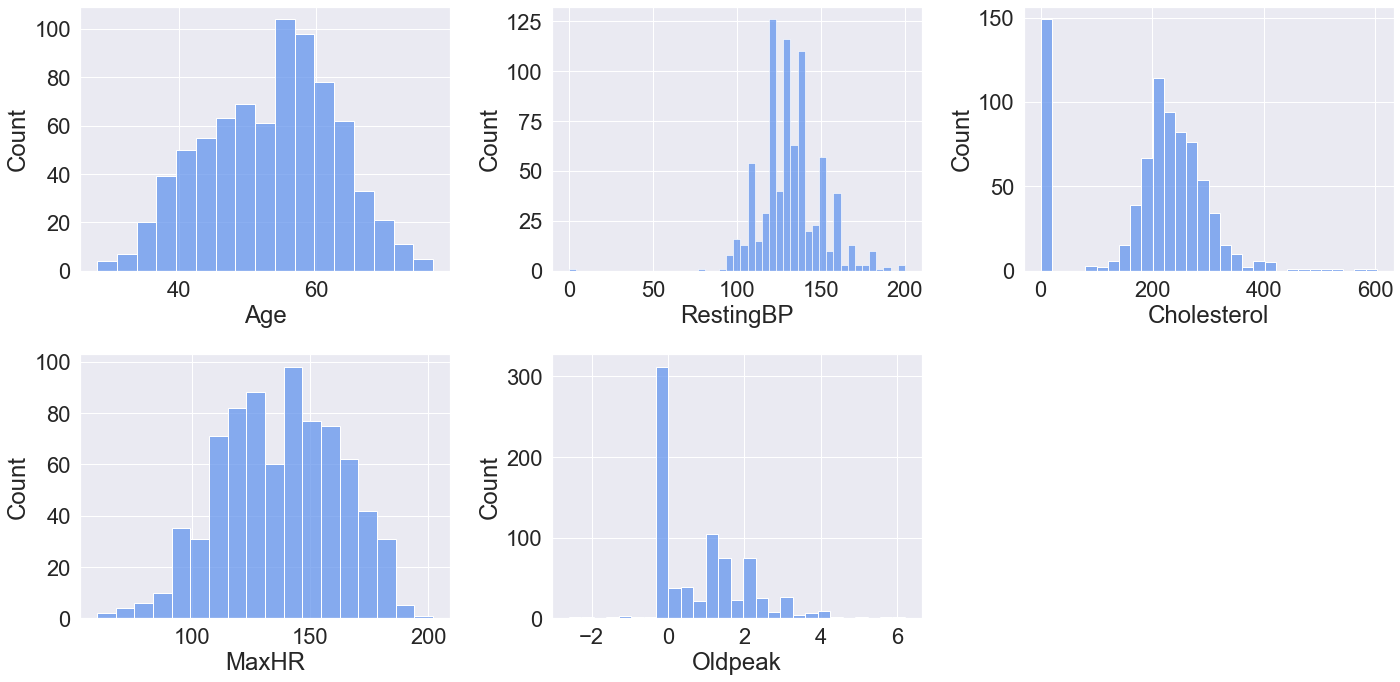

In [12]:
plt.figure(figsize = (20, 10))
sns.set(font_scale = 2)
for i, feature in enumerate(continuous_features):
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(data = heart_disease[continuous_features], x = feature, color = 'cornflowerblue')
plt.tight_layout()

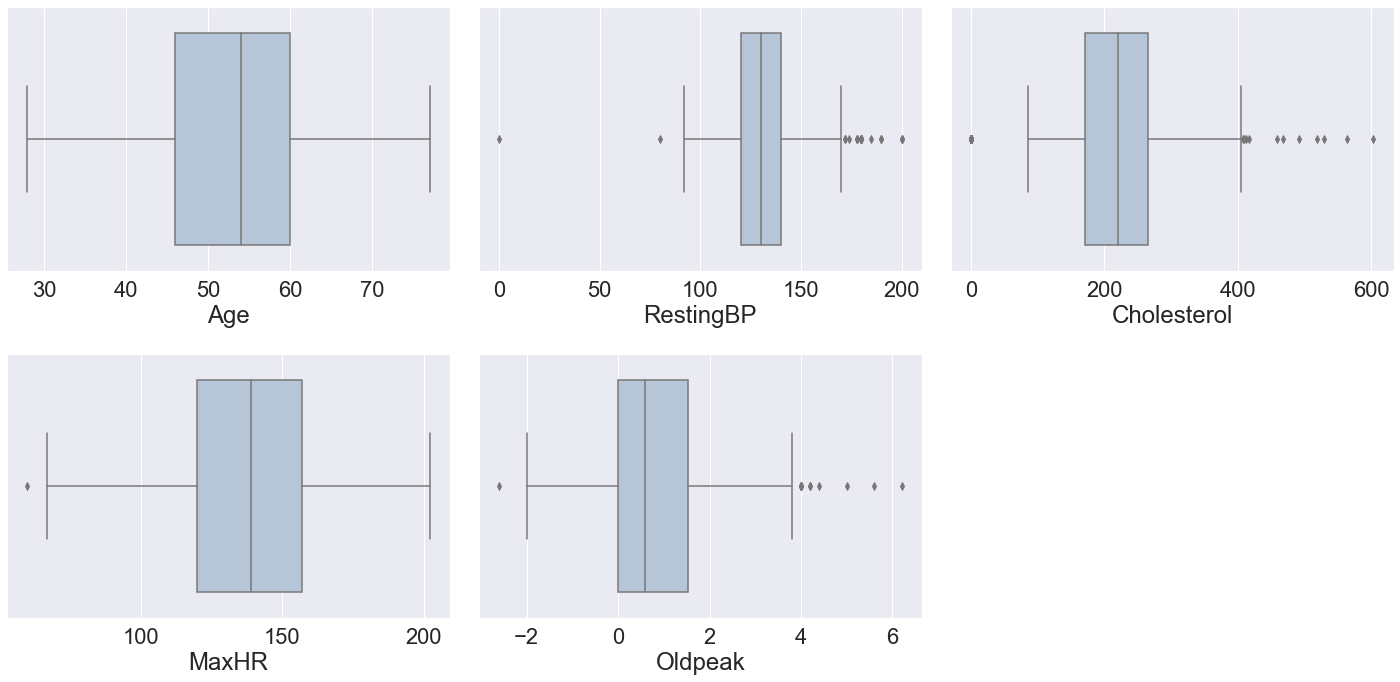

In [13]:
plt.figure(figsize = (20, 10))
for i, feature in enumerate(continuous_features):
    ax = plt.subplot(2, 3, i+1)
    sns.boxplot(x = heart_disease[continuous_features][feature], color = 'lightsteelblue')
plt.tight_layout()

We can see that there are abnormal values in 'Cholesterol' and 'RestingBP', we will check the statistical description of these features to get a better understanding:

In [14]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,53.328205,132.239744,196.921795,0.217949,137.419231,0.908846,0.552564
std,9.481147,18.473037,109.724841,0.413117,25.157984,1.088102,0.497548
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,46.000000,120.000000,171.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,220.000000,0.000000,139.000000,0.600000,1.000000
75%,60.000000,140.000000,265.000000,0.000000,157.000000,1.525000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The minimal value of 'Cholesterol' and 'RestingBP' is 0 which is not valid, thus we'll consider it as a missing value. For that purpose we'll replace all zero values in 'Cholesterol' and 'RestingBP' to NaN:

In [15]:
cols = ["RestingBP", "Cholesterol"]
heart_disease[cols] = heart_disease[cols].replace({0:np.nan})
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,780.000000,779.000000,631.000000,780.000000,780.000000,780.000000,780.000000
mean,53.328205,132.409499,243.421553,0.217949,137.419231,0.908846,0.552564
std,9.481147,17.865765,59.581688,0.413117,25.157984,1.088102,0.497548
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,46.000000,120.000000,206.500000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,236.000000,0.000000,139.000000,0.600000,1.000000
75%,60.000000,140.000000,274.000000,0.000000,157.000000,1.525000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Now we are able to see that the values for 'Cholesterol' and 'RestingBP' are at normal range.
In addition we can see that we now have missing values in our data set:

In [16]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       149
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

We will choose how to treat these missing values at the preprocess step.

**Analysis of categorical features:**


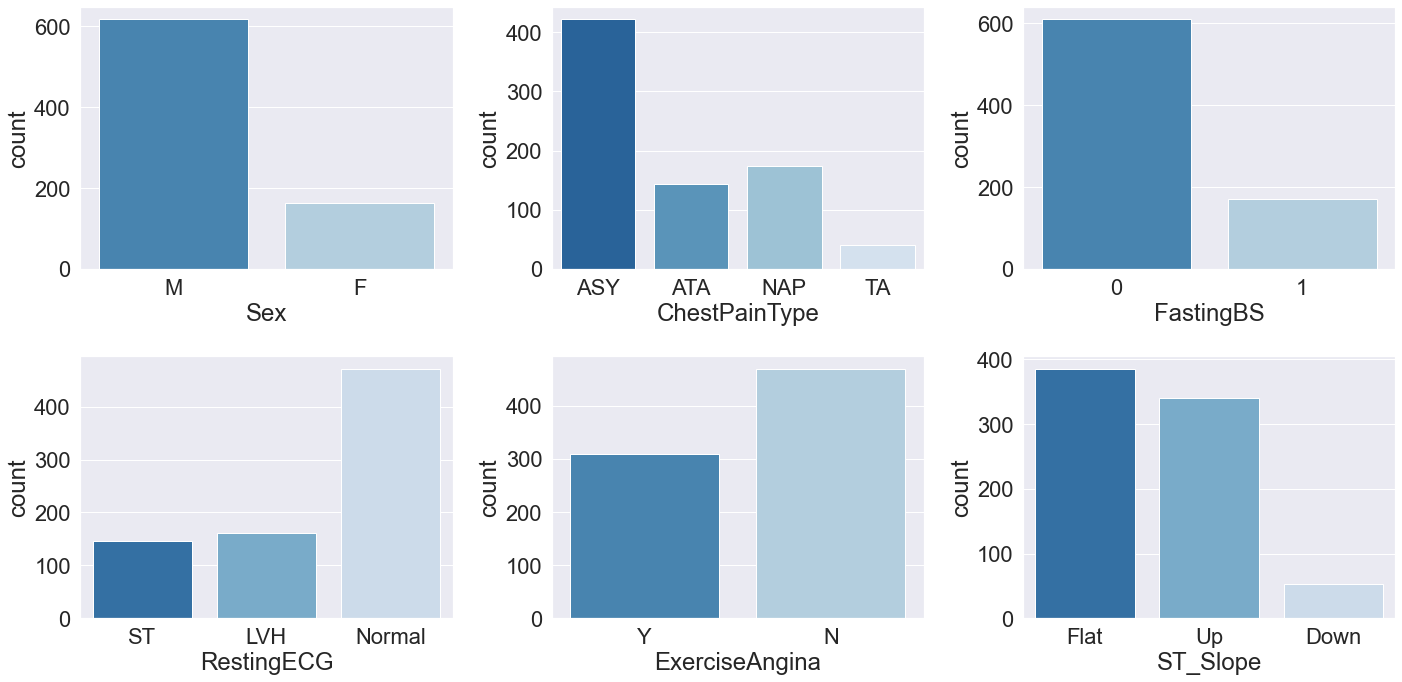

In [17]:
plt.figure(figsize = (20, 10))
for i, feature in enumerate(categorical_features):
    ax = plt.subplot(2, 3, i+1)
    sns.countplot(data=heart_disease, x = feature, palette='Blues_r')
plt.tight_layout()

### Checking target imbalance:

The percentage of each of the possible outputs is:

In [18]:
heart_disease['HeartDisease'].value_counts(normalize=True) * 100

1    55.25641
0    44.74359
Name: HeartDisease, dtype: float64

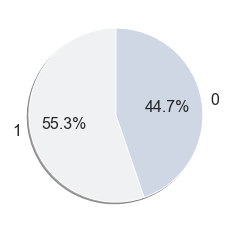

In [19]:
colors = sns.color_palette('light:b')
plt.pie(heart_disease['HeartDisease'].value_counts(), labels=['1', '0'], colors=colors, autopct='%1.1f%%',startangle=90, textprops={'fontsize':16}, shadow=True)
plt.show()

We can see that the data is balanced, which means that we can use 'accuracy' as our evaluation metric.

###  <font color='red'>TODO: maybe add somthing about that we prefer that our recall would be higher?</font>

## 3. <u>Data preprocess</u>:

### Encoding Categorical Values:

In [20]:
heart_disease.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP         float64
Cholesterol       float64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Check if all categorical features are assignd with values that they supposed to get.

In [21]:
for col in categorical_features:
    print(f"\n\033[1mThe distribution of categorical valeus in '{col}' feature is:\033[0m")
    print(heart_disease[col].value_counts())


The distribution of categorical valeus in 'Sex' feature is:
M    618
F    162
Name: Sex, dtype: int64

The distribution of categorical valeus in 'ChestPainType' feature is:
ASY    422
NAP    174
ATA    144
TA      40
Name: ChestPainType, dtype: int64

The distribution of categorical valeus in 'FastingBS' feature is:
0    610
1    170
Name: FastingBS, dtype: int64

The distribution of categorical valeus in 'RestingECG' feature is:
Normal    472
LVH       161
ST        147
Name: RestingECG, dtype: int64

The distribution of categorical valeus in 'ExerciseAngina' feature is:
N    470
Y    310
Name: ExerciseAngina, dtype: int64

The distribution of categorical valeus in 'ST_Slope' feature is:
Flat    386
Up      341
Down     53
Name: ST_Slope, dtype: int64


Use label encoding on 'Sex', 'ExerciseAngina' and 'ST_Slope':

In [22]:
cat_to_num = {
            "Sex": {"M": 0, "F": 1},
            "ExerciseAngina": {"N": 0, "Y": 1},
#             "ChestPainType": {"ASY": 0, "TA": 1, "ATA": 2, "NAP": 3},
            }

heart_disease = heart_disease.replace(cat_to_num)

Perform one hot encoding to 'ChestPainType', 'RestingECG' and 'ST_Slope':

In [23]:
# heart_disease = pd.get_dummies(heart_disease, columns=["RestingECG", "ST_Slope"], prefix=["R_ECG", "ST_Slope"])
heart_disease = pd.get_dummies(heart_disease, columns=["ChestPainType", "RestingECG", "ST_Slope"], prefix=["CPT", "R_ECG", "ST_Slope"])
# heart_disease = pd.get_dummies(heart_disease, columns=["ChestPainType", "RestingECG"], prefix=["CPT", "R_ECG"])

heart_disease.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,CPT_ASY,CPT_ATA,CPT_NAP,CPT_TA,R_ECG_LVH,R_ECG_Normal,R_ECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
100,65,0,130.0,275.0,0,115,1,1.0,1,1,0,0,0,0,0,1,0,1,0
147,43,1,120.0,249.0,0,176,0,0.0,0,0,1,0,0,0,0,1,0,0,1
626,53,0,142.0,226.0,0,111,1,0.0,0,1,0,0,0,1,0,0,0,0,1
161,49,0,128.0,212.0,0,96,1,0.0,1,1,0,0,0,0,1,0,0,1,0
227,38,0,92.0,117.0,0,134,1,2.5,1,1,0,0,0,0,1,0,0,1,0


We can see now that we no longer have non-numeric data types in our data set:

In [24]:
heart_disease.dtypes

Age                 int64
Sex                 int64
RestingBP         float64
Cholesterol       float64
FastingBS           int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
HeartDisease        int64
CPT_ASY             uint8
CPT_ATA             uint8
CPT_NAP             uint8
CPT_TA              uint8
R_ECG_LVH           uint8
R_ECG_Normal        uint8
R_ECG_ST            uint8
ST_Slope_Down       uint8
ST_Slope_Flat       uint8
ST_Slope_Up         uint8
dtype: object

### Missing values:

In order to decide how to treat the missing values in our data, we will run logistic regression on two options:
1. Data with imputation of missing values
2. Data with dropped missing values

After that we'll choose the option that gives the lower cross validation score.

In [25]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
RestingBP           1
Cholesterol       149
FastingBS           0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
HeartDisease        0
CPT_ASY             0
CPT_ATA             0
CPT_NAP             0
CPT_TA              0
R_ECG_LVH           0
R_ECG_Normal        0
R_ECG_ST            0
ST_Slope_Down       0
ST_Slope_Flat       0
ST_Slope_Up         0
dtype: int64

To treat the only missing value of 'RestingBP', we are going to replace it with the mean of 'RestingBP':

In [26]:
RestingBP_mean = heart_disease['RestingBP'].mean()
heart_disease['RestingBP'] = heart_disease['RestingBP'].fillna(RestingBP_mean)

In [27]:
heart_disease_samples_dropped = heart_disease.dropna()
heart_disease_samples_dropped.shape

(631, 19)

In [28]:
heart_disease_feature_dropped = heart_disease.dropna(axis=1)
heart_disease_feature_dropped.shape

(780, 18)

We'll now examine the distribution of 'Cholesterol' feature to decide whether to replace it with the mean or the median value:

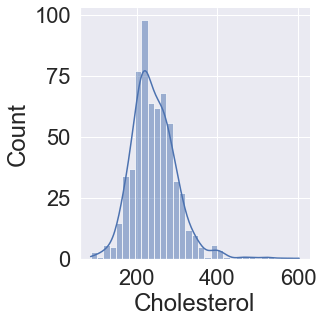

In [29]:
sns.displot(heart_disease.Cholesterol, kde= True)

We can see that the data is skewed and may contain outliers. Outliers data points will have a significant impact on the mean and hence, in such cases, it is not recommended to use the mean for replacing the missing values.When the data is skewed, it is good to consider using the median value for replacing the missing values.

In [30]:
cholesterol_median = heart_disease['Cholesterol'].median()

heart_disease_median_imputation = heart_disease.copy(deep=True) # Make a copy of the Dataframe
heart_disease_median_imputation['Cholesterol'] = heart_disease_median_imputation['Cholesterol'].fillna(cholesterol_median)

In [31]:
heart_disease_median_imputation.isnull().sum()

Age               0
Sex               0
RestingBP         0
Cholesterol       0
FastingBS         0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
HeartDisease      0
CPT_ASY           0
CPT_ATA           0
CPT_NAP           0
CPT_TA            0
R_ECG_LVH         0
R_ECG_Normal      0
R_ECG_ST          0
ST_Slope_Down     0
ST_Slope_Flat     0
ST_Slope_Up       0
dtype: int64

In [32]:
X_knn_col = heart_disease.columns

from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=1)
knn_imputation = knn_imputer.fit_transform(heart_disease)

knn_imputation = pd.DataFrame(knn_imputation, columns=X_knn_col)
X_knn_imputation = knn_imputation.drop(["HeartDisease"], axis=1)
y_knn_imputation = knn_imputation["HeartDisease"]

**compare performance:**

In [33]:
X_samples_dropped = heart_disease_samples_dropped.drop(["HeartDisease"], axis=1)
y_samples_dropped = heart_disease_samples_dropped["HeartDisease"]

X_feature_dropped = heart_disease_feature_dropped.drop(["HeartDisease"], axis=1)
y_feature_dropped = heart_disease_feature_dropped["HeartDisease"]

X_median_imputation = heart_disease_median_imputation.drop(["HeartDisease"], axis=1)
y_median_imputation = heart_disease_median_imputation["HeartDisease"]

In [34]:
# Prepare arguments for 'compare' function
X_datasets = [X_samples_dropped, X_feature_dropped, X_median_imputation, X_knn_imputation]
datasets_str = ['X_samples_dropped', 'X_feature_dropped', 'X_median_imputation', 'X_knn_imputation']
y_datasets = [y_samples_dropped, y_feature_dropped, y_median_imputation, y_knn_imputation]

# Function described in 'Auxiliary_functions' file
compare(X_datasets, datasets_str, y_datasets)

,train_score,cv_score
X_samples_dropped,0.879947,0.869991
X_feature_dropped,0.867308,0.856410
X_median_imputation,0.870833,0.860256
X_knn_imputation,0.870513,0.862821


###  <font color='red'>TODO: explain and change partition to x_train and y_train accordingly</font>


In [35]:
heart_disease = knn_imputation
# heart_disease = heart_disease_feature_dropped
# continuous_features.remove('Cholesterol')

### Feature engineering:

In [36]:
# Didn't improve accuracy - 0.86 vs. 0.86

heart_disease["MaxHR_precent"] = (heart_disease["MaxHR"] / (220 - heart_disease["Age"])) * 100
continuous_features.append("MaxHR_precent")
heart_disease.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,CPT_ASY,CPT_ATA,CPT_NAP,CPT_TA,R_ECG_LVH,R_ECG_Normal,R_ECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,MaxHR_precent
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,53.328205,0.207692,132.409499,244.326923,0.217949,137.419231,0.397436,0.908846,0.552564,0.541026,0.184615,0.223077,0.051282,0.206410,0.605128,0.188462,0.067949,0.494872,0.437179,82.406603
std,9.481147,0.405916,17.854294,61.688247,0.413117,25.157984,0.489682,1.088102,0.497548,0.498634,0.388234,0.416577,0.220714,0.404988,0.489137,0.391331,0.251819,0.500295,0.496356,14.096041
min,28.000000,0.000000,80.000000,85.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.502959
25%,46.000000,0.000000,120.000000,206.750000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.604530
50%,54.000000,0.000000,130.000000,236.000000,0.000000,139.000000,0.000000,0.600000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,82.680831
75%,60.000000,0.000000,140.000000,274.000000,0.000000,157.000000,1.000000,1.525000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,93.534156
max,77.000000,1.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,114.012739


In [37]:
# heart_disease["ST_decrease_Level"] = heart_disease["Oldpeak"] * heart_disease["ST_Slope_Down"]
# heart_disease.describe()

### Outliers:

We would like to check now whether we have to remove outliers or not:

In [38]:
for feature in continuous_features: 
    heart_disease_no_outliers = remove_outliers(heart_disease, feature)

In [39]:
heart_disease_no_outliers.shape

(779, 20)

In [40]:
heart_disease.shape

(780, 20)

In [41]:
X_w_outliers = heart_disease.drop(["HeartDisease"], axis=1)
y_w_outliers = heart_disease["HeartDisease"]

X_no_outliers = heart_disease_no_outliers.drop(["HeartDisease"], axis=1)
y_no_outliers = heart_disease_no_outliers["HeartDisease"]

In [42]:
# Prepare arguments for 'compare' function
X_datasets = [X_w_outliers, X_no_outliers]
datasets_str = ['X_w_outliers', 'X_no_outliers']
y_datasets = [y_w_outliers, y_no_outliers]

# Function described in 'Auxiliary_functions' file
compare(X_datasets, datasets_str, y_datasets)

,train_score,cv_score
X_w_outliers,0.869231,0.862821
X_no_outliers,0.869705,0.862647


In [43]:
X_train = X_w_outliers
y_train = y_w_outliers

### Feature Selection:

In [44]:
feature_sel_LR = LogisticRegression()
SFS = sfs(feature_sel_LR, n_features_to_select=14, direction='backward', scoring='accuracy', n_jobs=-1)
SFS = SFS.fit(X_train, y_train)

mask = SFS.get_support()
new_features = list(X_train.columns[mask])
print(f"Features selected for model are: {new_features}")

Features selected for model are: ['Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'CPT_ASY', 'CPT_ATA', 'CPT_NAP', 'R_ECG_LVH', 'ST_Slope_Flat', 'ST_Slope_Up', 'MaxHR_precent']


In [45]:
X_train_FS = SFS.transform(X_train)

In [46]:
# Prepare arguments for 'compare' function
X_datasets = [X_train, X_train_FS]
datasets_str = ['X_train', 'X_train_FS']
y_datasets = [y_train, y_train]

# Function described in 'Auxiliary_functions' file
compare(X_datasets, datasets_str, y_datasets)

,train_score,cv_score
X_train,0.869231,0.862821
X_train_FS,0.869872,0.867949


In [47]:
X_train = X_train_FS

### Feature Scaling:

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

normalization_scaler = MinMaxScaler()
standartization_scaler = StandardScaler()

X_Normalized = normalization_scaler.fit_transform(X_train)
X_standartisized = standartization_scaler.fit_transform(X_train)

In [49]:
# Prepare arguments for 'compare' function
X_datasets = [X_Normalized, X_standartisized]
datasets_str = ['X_Normalized', 'X_standartisized']
y_datasets = [y_train, y_train]

# Function described in 'Auxiliary_functions' file
compare(X_datasets, datasets_str, y_datasets)

,train_score,cv_score
X_Normalized,0.870513,0.867949
X_standartisized,0.869231,0.864103


In [50]:
X_train = X_Normalized

### Prepare test set:

In [51]:
test_set= pd.concat([X_test, pd.DataFrame(y_test)], axis=1)
test_set[cols] = test_set[cols].replace({0:np.nan})
test_set = test_set.replace(cat_to_num)
test_set = pd.get_dummies(test_set, columns=["ChestPainType", "RestingECG", "ST_Slope"], prefix=["CPT", "R_ECG", "ST_Slope"])

# test_set = test_set.dropna(axis=1)

col = test_set.columns
test_set = knn_imputer.transform(test_set)
test_set = pd.DataFrame(test_set, columns=col)

test_set["MaxHR_precent"] = (test_set["MaxHR"] / (220 - test_set["Age"])) * 100

X_test = test_set.drop(["HeartDisease"], axis=1)
y_test = test_set["HeartDisease"]
X_test = SFS.transform(X_test)
X_test_FS = X_test
X_test = normalization_scaler.transform(X_test)

## 4. <u>Modeling</u>:

### Implementation of Logistic Regression (LR):

In [52]:
l1_ratio = np.linspace(0, 1, 20)
C = np.logspace(0, 10, 20)
param_grid = (
             {"penalty" : ["elasticnet"], "l1_ratio" : l1_ratio, "C" : C},
             {"penalty" : ["l1", "l2"], "C" : C},
             )
             
model_LR = LogisticRegression(max_iter=3000, solver='saga', n_jobs=-1, random_state=123)
model_LR = GridSearchCV(model_LR, param_grid = param_grid, scoring='recall', n_jobs=-1)
model_LR.fit(X_train, y_train)
predictions_LR = model_LR.predict(X_test)

### Implementation of Support Vector Machine (SVM):

In [53]:
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': ["scale", "auto", 1,0.1,0.01,0.001],
              'kernel': ['rbf', 'linear']}
             
model_SVM = SVC()
model_SVM = GridSearchCV(model_SVM, param_grid = param_grid, scoring='recall', n_jobs=-1)
model_SVM.fit(X_train, y_train)
predictions_SVM = model_LR.predict(X_test)

### Implementation of k-Nearest Neighbors (kNN):

In [54]:
model_knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1,50,2)}
model_knn = GridSearchCV(model_knn, param_grid, scoring='recall')
model_knn.fit(X_train, y_train)

predictions_knn = model_knn.predict(X_test)

### Implementation of Random Forest (RF):

In [64]:
param_grid = {'n_estimators':[15, 25, 50, 75],
             'max_features':[2, 3],
             'max_depth':[2, 3],
             'min_samples_split':[2, 5, 8, 10]}

model_RF= RandomForestClassifier(random_state = 0)
model_RF = GridSearchCV(model_RF, param_grid=param_grid, scoring = "recall", n_jobs = -1)
model_RF.fit(X_train_FS, y_train)  
predictions_RF = model_RF.predict(X_test_FS)

## 4. <u>Evaluation</u>:

#### Evaluation metrics for logistic regression:

In [56]:
model_evaluation(model_LR, X_train, predictions_LR, y_test)

Best parameters found:  {'C': 1.0, 'l1_ratio': 0.8421052631578947, 'penalty': 'elasticnet'}
Best estimator found:  LogisticRegression(l1_ratio=0.8421052631578947, max_iter=3000, n_jobs=-1,
                   penalty='elasticnet', random_state=123, solver='saga')
Best CV score found:  0.8979149959903768
Test score:  0.855072463768116
              precision    recall  f1-score   support

    target 0       0.87      0.79      0.83        61
    target 1       0.84      0.91      0.88        77

    accuracy                           0.86       138
   macro avg       0.86      0.85      0.85       138
weighted avg       0.86      0.86      0.85       138

Confusion matrix:
          Predicted 0  Predicted 1
Actual 0           48           13
Actual 1            7           70


#### Evaluation metrics for support vector machine:

In [57]:
model_evaluation(model_SVM, X_train, predictions_SVM, y_test)

Best parameters found:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Best estimator found:  SVC(C=0.1, gamma=0.001)
Best CV score found:  1.0
Test score:  0.855072463768116
              precision    recall  f1-score   support

    target 0       0.87      0.79      0.83        61
    target 1       0.84      0.91      0.88        77

    accuracy                           0.86       138
   macro avg       0.86      0.85      0.85       138
weighted avg       0.86      0.86      0.85       138

Confusion matrix:
          Predicted 0  Predicted 1
Actual 0           48           13
Actual 1            7           70


#### Evaluation metrics for k-nearest neighbors:

In [58]:
model_evaluation(model_knn, X_train, predictions_knn, y_test)

Best parameters found:  {'n_neighbors': 19}
Best estimator found:  KNeighborsClassifier(n_neighbors=19)
Best CV score found:  0.9094627105052124
Test score:  0.8623188405797102
              precision    recall  f1-score   support

    target 0       0.90      0.77      0.83        61
    target 1       0.84      0.94      0.88        77

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138

Confusion matrix:
          Predicted 0  Predicted 1
Actual 0           47           14
Actual 1            5           72


#### Evaluation metrics for random forest:

In [65]:
model_evaluation(model_RF, X_train_FS, predictions_RF, y_test)

Best parameters found:  {'max_depth': 3, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 25}
Best estimator found:  RandomForestClassifier(max_depth=3, max_features=2, n_estimators=25,
                       random_state=0)
Best CV score found:  0.8955092221331196
Test score:  0.8623188405797102
              precision    recall  f1-score   support

    target 0       0.90      0.77      0.83        61
    target 1       0.84      0.94      0.88        77

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138

Confusion matrix:
          Predicted 0  Predicted 1
Actual 0           47           14
Actual 1            5           72


In [66]:
# from sklearn import tree

# model_tree = model_RF.best_estimator_
# model_tree.fit(X_train_FS, y_train)  

# for i in range(len(model_tree.estimators_)):
#     plt.figure(figsize=(15,15))
#     _ = tree.plot_tree(model_tree.estimators_[i], feature_names=new_features, class_names=True, filled=True)